# 图像去噪

### 目标
在本章中，
- 你将学习用于去除图像中噪声的非局部均值去噪算法。
- 你将看到不同的函数，例如cv.fastNlMeansDenoising()，cv.fastNlMeansDenoisingColored()等。

### 理论
在前面的章节中，我们已经看到了许多图像平滑技术，例如高斯模糊，中值模糊等，它们在某种程度上可以消除少量噪声。在这些技术中，我们在像素周围采取了一个较小的邻域，并进行了一些操作，例如高斯加权平均值，值的中位数等来替换中心元素。简而言之，在像素处去除噪声是其周围的局部现象。
有噪声的性质。

通常认为噪声是零均值的随机变量。考虑一个有噪声的像素，$p=p_0+n$，其中$p_0$是像素的真实值，$n$是该像素中的噪声。你可以从不同的图像中获取大量相同的像素（例如N）并计算其平均值。理想情况下，由于噪声的平均值为零，因此应该得到$p = p_0$。

你可以通过简单的设置自己进行验证。将静态相机固定在某个位置几秒钟。这将为你提供很多帧或同一场景的很多图像。然后编写一段代码，找到视频中所有帧的平均值（这对你现在应该太简单了）。
比较最终结果和第一帧。你会看到噪声减少。不幸的是，这种简单的方法对摄像机和场景的运动并不稳健。通常，只有一张嘈杂的图像可用。

因此想法很简单，我们需要一组相似的图像来平均噪声。考虑图像中的一个小窗口（例如5x5窗口）。
很有可能同一修补程序可能位于图像中的其他位置。有时在它周围的一个小社区中。一起使用这些相似的补丁并找到它们的平均值怎么办？对于那个特定的窗口，这很好。请参阅下面的示例图片：

![](data/nlm_patch.jpg)

图像中的蓝色补丁看起来很相似。绿色补丁看起来很相似。因此，我们获取一个像素，在其周围获取一个小窗口，在图像中搜索相似的窗口，对所有窗口求平均，然后用得到的结果替换该像素。此方法是“非本地均值消噪”。与我们之前看到的模糊技术相比，它花费了更多时间，但是效果非常好。更多信息和在线演示可在其他资源的第一个链接中找到。

对于彩色图像，图像将转换为CIELAB色彩空间，然后分别对L和AB分量进行降噪。

### OpenCV中的图像去噪
OpenCV提供了此方法的四个变体。

1. **cv.fastNlMeansDenoising**()-处理单个灰度图像
2. **cv.fastNlMeansDenoisingColored**()-处理彩色图像。
3. **cv.fastNlMeansDenoisingMulti**()-处理在短时间内捕获的图像序列（灰度图像）
4. **cv.fastNlMeansDenoisingColoredMulti**()-与上面相同，但用于彩色图像。

常用参数为：
- h：决定滤波器强度的参数。较高的h值可以更好地消除噪点，但同时也可以消除图像细节。（可以设为10）
- hForColorComponents：与h相同，但仅用于彩色图像。（通常与h相同）
- templateWindowSize：应为奇数。（建议设为7）
- searchWindowSize：应为奇数。（建议设为21）

请访问其他资源中的第一个链接，以获取有关这些参数的更多详细信息。
我们将在此处演示2和3。剩下的留给你。

1. **cv.fastNlMeansDenoisingColored**()
如上所述，它用于消除彩色图像中的噪点。（噪声可能是高斯的）。请参阅以下示例：

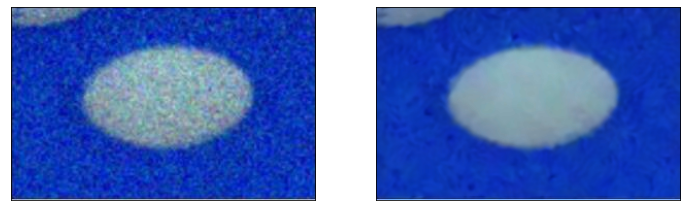

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# img = cv.imread('output/frame.png')
img = cv.imread('data/die.png')

dst = cv.fastNlMeansDenoisingColored(img,None,10,10,7,21)

plt.figure(figsize=(12,6))
plt.subplot(121),plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])

plt.show()

2. **cv.fastNlMeansDenoisingMulti**()
现在，我们将对视频应用相同的方法。第一个参数是噪声帧列表。第二个参数`imgToDenoiseIndex`指定我们需要去噪的帧，为此，我们在输入列表中传递帧的索引。第三是`temporalWindowSize`，它指定要用于降噪的附近帧的数量。应该很奇怪。在那种情况下，总共使用`temporalWindowSize`帧，其中中心帧是要被去噪的帧。例如，你传递了一个5帧的列表作为输入。令`imgToDenoiseIndex = 2,temporalWindowSize =3`。然后使用`frame-1`，`frame-2`和`frame-3`去噪`frame-2`。让我们来看一个例子。

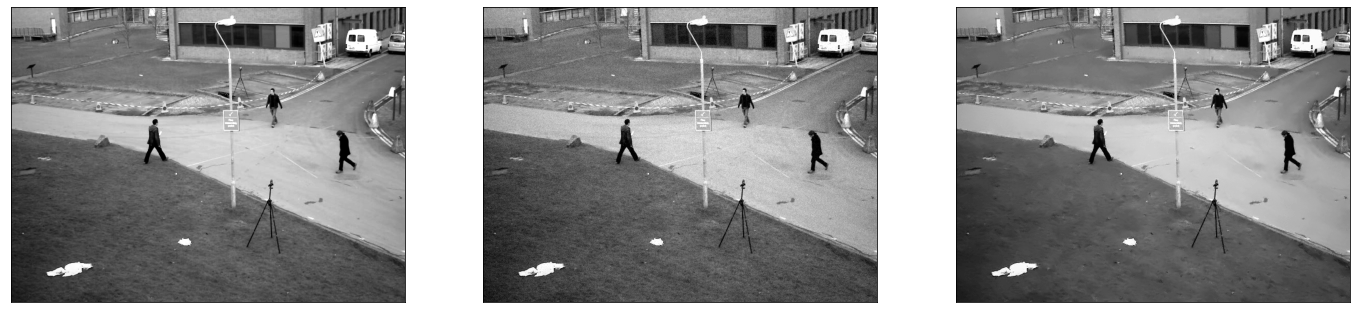

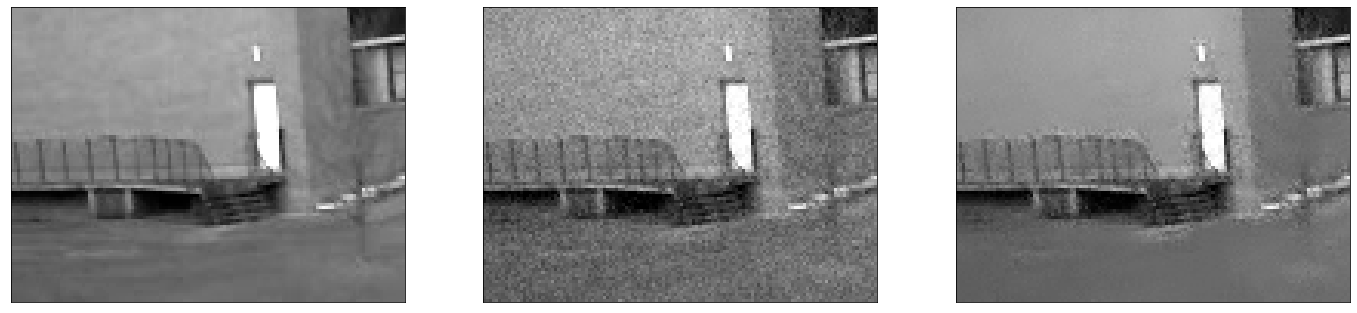

In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

cap = cv.VideoCapture('data/vtest.avi')

# 创建5个帧的列表
img = [cap.read()[1] for i in range(5)]

# 将所有转化为灰度
gray = [cv.cvtColor(i, cv.COLOR_BGR2GRAY) for i in img]

# 将所有转化为float64
gray = [np.float64(i) for i in gray]

# 创建方差为25的噪声
noise = np.random.randn(*gray[1].shape)*10

# 在图像上添加噪声
noisy = [i+noise for i in gray]

# 转化为unit8
noisy = [np.uint8(np.clip(i,0,255)) for i in noisy]

# 对第三帧进行降噪
dst = cv.fastNlMeansDenoisingMulti(noisy, 2, 5, None, 8, 7, 21)

plt.figure(figsize=(24,8))

plt.subplot(131),plt.imshow(gray[2],'gray')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(noisy[2],'gray')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(dst,'gray')
plt.xticks([]), plt.yticks([])
plt.show()

# cv.imwrite('output/frame.png', noisy[2])

# 左上角放大版
img1 = gray[2][0:96, 0:128]
img2 = noisy[2][0:96, 0:128]
img3 = dst[0:96, 0:128]

imgs = [img1, img2, img3]

plt.figure(figsize=(24,8))

for i in range(3):
  plt.subplot(1, 3, i+1),plt.imshow(imgs[i],'gray')
  plt.xticks([]), plt.yticks([])

plt.show()

计算需要花费大量时间。结果，第一个图像是原始帧，第二个是噪声帧，第三个是去噪图像。

### 附加资源
1. http://www.ipol.im/pub/art/2011/bcm_nlm/ (它包含详细信息，在线演示等。强烈建议访问。我们的测试图像是从此链接生成的)
2. Online course at coursera (这里拍摄的第一张图片)

### 练习